# Introduction

------------------------------
## Mission - Etudiez la faisabilité d'un moteur de classification d'articles
------------------------------

Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  **il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.**

**Linda**, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un **moteur de classification** des articles en différentes catégories, à partir du texte (en anglais) et de l’image.

Voici le mail qu’elle vous a envoyé.

*Bonjour,*

*Merci pour ton aide sur ce projet !*

*Ta mission sera de réaliser **une étude de faisabilité d'un moteur de classification automatique** d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.*

*Pourrais-tu **analyser** les **descriptions textuelles** et les **images des produits**, au travers des étapes suivantes :*

* *Un **prétraitement** des données texte et image*
* *Une **extraction** de features*
* *Une **réduction** en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle*
* *Une **analyse** du **graphique** afin de conclure, à l’aide des descriptions ou des images, sur la **faisabilité de regrouper automatiquement** des produits de même catégorie*
* *Une réalisation d’une **mesure pour confirmer ton analyse visuelle**, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters*
 
*Pourrais-tu nous démontrer ainsi la faisabilité de regrouper automatiquement des produits de même catégorie ?*

*Afin d’extraire les **features image**, il sera nécessaire de mettre en œuvre :*
* *un algorithme de type SIFT / ORB / SURF ;*
* *un algorithme de type CNN Transfer Learning.*

*Afin d’extraire les **features texte**, il sera nécessaire de mettre en œuvre :*
* *deux approches de type bag-of-words, comptage simple de mots et Tf-idf ;*
* *une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;*
* *une approche de type word/sentence embedding avec BERT ;*
* *une approche de type word/sentence embedding avec USE (Universal Sentence Encoder).*
 
*Pour t’aider, en deuxième pièce jointe, tu trouveras un **exemple** de Notebook mettant en œuvre les approches d’extraction de features d’images sur un autre dataset.*

*Merci encore,*

*Linda*

*PS : J’ai bien vérifié qu’il n’y avait aucune contrainte de propriété intellectuelle sur les données et les images.*

# Imports

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import words, stopwords

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lalende/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lalende/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Initialize sns
sns.set()

# Lecture du dataset

In [4]:
# Read the dataset from the csv file 
df = pd.read_csv("./data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

## Caractéristiques du jeu de données

In [5]:
# Print dataframe infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
# Print the first rows of the dataframe
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [7]:
# Print the number of unique values by column
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

## Sélection des données de travail

Pour notre travail, nous allons utiliser les descriptions textuelles et les images des produits pour déterminer la catégorie des produits.

Nous avons vérifier à l'étape précédente qu'il n'y avait pas de doublons sur les colonnes image et description. En effet, pour 1050 uniq_id de produits, nous avons bien 1050 images et 1050 descriptions.

Nous conserverons donc toutes les descriptions, images. Etant donné que nous souhaitons déterminer la catégorie de produit, nous conserverons également product_category_tree.

In [8]:
# Define a list of columns to keep
selected_columns = ["product_category_tree", "image", "description"]
# Filter the dataframe with the selected columns
df = df[selected_columns]
df.head()

,product_category_tree,image,description
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...


# Analyse exploratoire

## Taille des documents

Calculons la longueur des textes

In [9]:
# Calculate the length of each text
len_of_texts = df["description"].apply(lambda i : len(i))

<Axes: xlabel='description'>

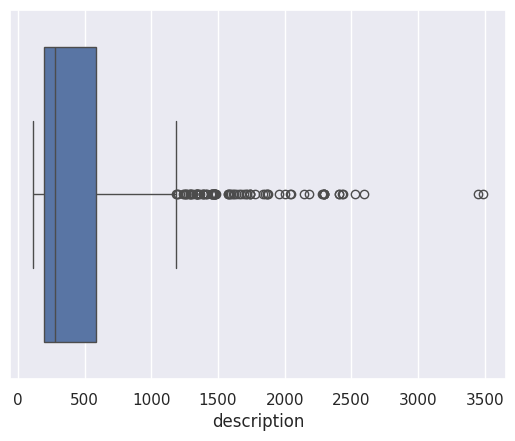

In [10]:
# Plot the length in a boxplot
sns.boxplot(len_of_texts, orient="h")

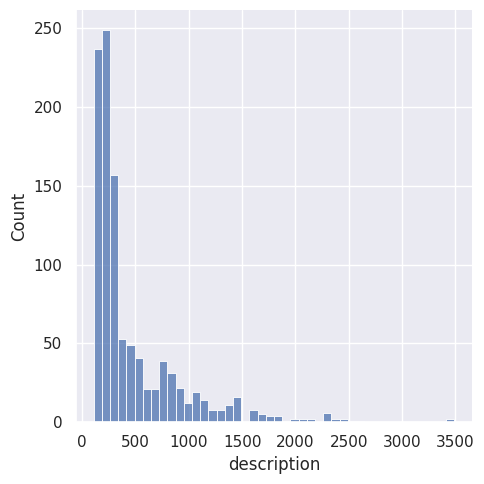

In [11]:
# Plot the distribution of the lengths
sns.displot(len_of_texts)

## Exploration des descriptions

In [12]:
# Select randomly 10 products
df_sample = df.sample(10)
df_sample.head()

,product_category_tree,image,description
773,"[""Baby Care >> Baby Bedding >> Baby Blankets >...",109e235d4838002246599f987d935c21.jpg,Buy Ireeya Abstract Single Coral Blanket Blue ...
411,"[""Beauty and Personal Care >> Fragrances >> De...",5c7b493625b5fc6689cae49d25e1ae17.jpg,Flipkart.com: Buy Aero Care Blue 4 Lady Combo ...
253,"[""Kitchen & Dining >> Cookware >> Pots & Pans ...",fb733e04ff2d72c59d8513eb574e81a2.jpg,Buy Metallino Hard Anodised WGlass Lid Kadhai ...
718,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",b33d82c619bf88c3e3bb8f53beab0c4b.jpg,Buy Home Originals Abstract Double Quilts & Co...
841,"[""Computers >> Laptop Accessories >> USB Gadge...",01089dc3618a0ab7304d784ef400b83d.jpg,Buy KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOB...


In [13]:
# For each line of our sample get the description and print it
for idx, ser in df_sample.iterrows():
    print(ser["description"])    
    # Add an empty line for clarity
    print("\n")

Buy Ireeya Abstract Single Coral Blanket Blue at Rs. 529 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


Flipkart.com: Buy Aero Care Blue 4 Lady Combo Set online only for Rs. 165 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!


Buy Metallino Hard Anodised WGlass Lid Kadhai 3.5 L for Rs.1132 online. Metallino Hard Anodised WGlass Lid Kadhai 3.5 L at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


Buy Home Originals Abstract Double Quilts & Comforters Multicolor at Rs. 1199 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!


Buy KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOBILES TR-256 USB USB Hub for Rs.1099 online. KLIQVIK SIX PORT USB HUB FOR I PHONE 4 MOBILES TR-256 USB USB Hub at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


Times SD_147 Casual Analog Watch  - For 

## Analyse des catégories

In [14]:
# For each line of our sample get the product_category_tree and print it
for idx, ser in df_sample.iterrows():
    print(ser["product_category_tree"])    
    # Add an empty line for clarity
    print("\n")

["Baby Care >> Baby Bedding >> Baby Blankets >> Ireeya Baby Blankets"]


["Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Aero Care Combos"]


["Kitchen & Dining >> Cookware >> Pots & Pans >> Woks & Kadhais >> Metallino Woks & Kadhais"]


["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]


["Computers >> Laptop Accessories >> USB Gadgets >> KLIQVIK USB Gadgets"]


["Watches >> Wrist Watches >> Times Wrist Watches"]


["Watches >> Wrist Watches >> Times Wrist Watches"]


["Home Furnishing >> Bed Linen >> Bedsheets"]


["Computers >> Network Components >> Routers >> Asus Routers"]


["Baby Care >> Baby Bedding >> Baby Blankets >> Offspring Baby Blankets"]




Nous constatons, comme son nom l'indique, que cette variable contient le chemin dans l'arborescence des produits.

Nous souhaitons à présent décomposer ce chemin et analyser les données à notre disposition. 

Tout d'abord nous nous séparerons des caractères de début (**["**) et de fin (**"]**).

In [15]:
# Suppress the [" and "] characters
df["product_category_tree"] = df["product_category_tree"].apply(lambda i : i.replace('["', ''))
df["product_category_tree"] = df["product_category_tree"].apply(lambda i : i.replace('"]', ''))

In [16]:
# Get the values of the product_category_tree in a series
product_category_tree = df["product_category_tree"]
product_category_tree

0       Home Furnishing >> Curtains & Accessories >> C...
1       Baby Care >> Baby Bath & Skin >> Baby Bath Tow...
2       Baby Care >> Baby Bath & Skin >> Baby Bath Tow...
3       Home Furnishing >> Bed Linen >> Bedsheets >> S...
4       Home Furnishing >> Bed Linen >> Bedsheets >> J...
                              ...                        
1045    Baby Care >> Baby & Kids Gifts >> Stickers >> ...
1046    Baby Care >> Baby & Kids Gifts >> Stickers >> ...
1047    Baby Care >> Baby & Kids Gifts >> Stickers >> ...
1048    Baby Care >> Baby & Kids Gifts >> Stickers >> ...
1049    Baby Care >> Baby & Kids Gifts >> Stickers >> ...
Name: product_category_tree, Length: 1050, dtype: object

Décomposons la chaine de caractères dans un dataframe à chaque apparition du signe **>>**.

In [17]:
# Split the product_category_tree and store it in a list
categories_list = product_category_tree.apply(lambda i : i.split(">>"))
categories_list

0       [Home Furnishing ,  Curtains & Accessories ,  ...
1       [Baby Care ,  Baby Bath & Skin ,  Baby Bath To...
2       [Baby Care ,  Baby Bath & Skin ,  Baby Bath To...
3       [Home Furnishing ,  Bed Linen ,  Bedsheets ,  ...
4       [Home Furnishing ,  Bed Linen ,  Bedsheets ,  ...
                              ...                        
1045    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1046    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1047    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1048    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
1049    [Baby Care ,  Baby & Kids Gifts ,  Stickers , ...
Name: product_category_tree, Length: 1050, dtype: object

Etudions la taille des listes de catégories

In [18]:
# Go through categories_list and get the biggest list
max_size = 0
for i in range(len(categories_list)):
    # Check if the size is greater than the max_size already found
    if len(categories_list[i]) > max_size:
        # Set the max_size to the new max size
        max_size = len(categories_list[i])
# Print the max size
max_size

7

Nous avons donc au maximum 7 niveaux dans l'arborescence des catégories.

Stockons cela dans un dataframe pour l'analyser.

In [19]:
# Generate the columns names based on the max_size
columns = list(range(1,max_size+1))
# Create a dataframe from the list of categories
categories_df = pd.DataFrame(categories_list.to_list(), columns=columns)
categories_df

,1,2,3,4,5,6,7
0,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None
...,...,...,...,...,...,...,...
1045,Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None
1046,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None
1047,Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers,None,None,None
1048,Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None


Analysons notre dataframe

In [20]:
# Print the description of values in the dataframe
categories_df.describe()

,1,2,3,4,5,6,7
count,1050,1050,1047,679,405,127,57
unique,7,63,246,350,297,117,57
top,Home Furnishing,Wrist Watches,Deodorants,Combos,Dresses,Vitamins Shorts,Mom and Kid Baby Girl's Printed Green Top & P...
freq,150,149,65,64,21,3,1


La structure de la hierarchie, en plus de sa profondeur importante, semble complexe. Par exemple tous les produits non pas le même niveau d'arborescence.

Choisissons donc de ne conserver que le premier niveau.

In [21]:
# Get the first column of categories_df and set it in a new column in df
df["category"] = categories_df.iloc[:,0]
df.head()

,product_category_tree,image,description,category
0,Home Furnishing >> Curtains & Accessories >> C...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,Home Furnishing >> Bed Linen >> Bedsheets >> S...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,Home Furnishing >> Bed Linen >> Bedsheets >> J...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


Supprimons la colonne product_category_tree

In [22]:
df = df.drop("product_category_tree", axis=1)
df.head()

,image,description,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


# Text processing

## Lower

In [23]:
# Lower description and category
df["description"] = df["description"].apply(lambda i : i.lower())
df["category"] = df["category"].apply(lambda i : i.lower())
df.head()

,image,description,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features of elegance polyester multicolor ...,home furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,specifications of sathiyas cotton bath towel (...,baby care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,key features of eurospa cotton terry face towe...,baby care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,key features of santosh royal fashion cotton p...,home furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,key features of jaipur print cotton floral kin...,home furnishing


## Tokenisation

In [24]:
# Define the stop words list from NLTK library
stop_words = set(stopwords.words("english"))
print(stop_words)

{'being', 'how', 'these', 'after', 'nor', 'few', 'the', 'll', "shan't", 'won', 'who', 'his', 'yours', 'some', 'further', 'now', 've', 'hadn', 'wouldn', 're', 'it', 'a', 'those', 'does', 'once', 'why', "mightn't", 'because', "shouldn't", 'at', 't', "hadn't", 'for', 'with', 'through', 'very', 'couldn', 'ourselves', 'mustn', 'itself', 'but', 'were', 'or', 'up', "mustn't", "weren't", 'ours', 'myself', "doesn't", 's', 'do', 'of', 'where', 'that', 'm', 'weren', 'my', 'all', 'out', 'shouldn', 'such', 'having', 'again', 'above', 'about', 'isn', 'an', 'while', 'is', 'under', 'yourself', 'he', 'doing', 'what', "wouldn't", 'ma', 'before', 'down', 'as', 'will', 'any', 'no', "hasn't", 'shan', 'until', "it's", 'have', 'so', 'they', 'when', 'theirs', "you're", "couldn't", 'mightn', 'himself', 'i', 'don', 'didn', "haven't", "don't", 'which', 'there', "aren't", 'off', 'your', "that'll", 'y', 'here', 'its', 'between', 'by', 'below', 'whom', 'we', 'from', "should've", "won't", 'them', 'over', 'herself', 

In [25]:
def tokenize_text(text, force_is_alpha=False, rejoin=False):
    """Tokenize a text and remove stop words 
    --------------------
    Arguments :
        text : str : the text to process
        force_is_alpha : optionnal, bool : if True, exclude all tokens with a numeric character
        rejoin : optionnal, bool : if True, rejoin the list of tokens
    --------------------
    """
    # Instanciate a tokenizer
    tokenizer = RegexpTokenizer(r"\w+")
    # Tokenize
    tokens = tokenizer.tokenize(text)
    # Remove stop words
    tokens = [w for w in tokens if w not in stop_words]
    # Remove not alpha characters
    if force_is_alpha:
        tokens = [w for w in tokens if w .isalpha()]
    # Rejoin the tokens list if desired
    if rejoin:
        tokens = " ".join(tokens)
    # Return the cleaned text
    return tokens

## Lemmatization

In [26]:
def lemmatize_text(tokens, force_is_alpha=False, rejoin=False):
    """Lemmatize a tokenized text 
    --------------------
    Arguments :
        tokens : list : the tokenized text to process
        force_is_alpha : optionnal, bool : if True, exclude all tokens with a numeric character
        rejoin : optionnal, bool : if True, rejoin the list of tokens
    --------------------
    """
    # Instanciate a lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize
    transformed_text = [lemmatizer.lemmatize(w) for w in tokens]
    # Remove not alpha characters
    if force_is_alpha:
        transformed_text = [w for w in transformed_text if w .isalpha()]
    # Rejoin the tokens list if desired
    if rejoin:
        transformed_text = " ".join(transformed_text)
    # Return the cleaned text
    return transformed_text

## Stemming

In [27]:
def stemmatize_text(tokens, force_is_alpha=False, rejoin=False):
    """stemmatize a tokenized text 
    --------------------
    Arguments :
        tokens : list : the tokenized text to process
        force_is_alpha : optionnal, bool : if True, exclude all tokens with a numeric character
        rejoin : optionnal, bool : if True, rejoin the list of tokens
    --------------------
    """
    # Instanciate a lemmatizer
    stemmer = PorterStemmer()
    # Lemmatize
    transformed_text = [stemmer.stem(w) for w in tokens]
    # Remove not alpha characters
    if force_is_alpha:
        transformed_text = [w for w in transformed_text if w .isalpha()]
    # Rejoin the tokens list if desired
    if rejoin:
        transformed_text = " ".join(transformed_text)
    # Return the cleaned text
    return transformed_text

## Processing final

In [28]:
def process_text(text, lem_or_stem="lem", force_is_alpha=True, rejoin=True):
    """Perform the cleaning 
    --------------------
    Arguments :
        text : str : the text to clean
        lem_or_stem : str : Choose between "lem" to lemmatize the text or "stem" to stemmatize it
        force_is_alpha : optionnal, bool : if True, exclude all tokens with a numeric character
        rejoin : optionnal, bool : if True, rejoin the list of tokens
    --------------------
    """
    # First tokenize the text and get a list of tokens
    tokenized_text = tokenize_text(text, force_is_alpha)
    # If "lem" is chosen, lemmatize the tokens get previously
    if lem_or_stem == "lem":
        final_text = lemmatize_text(tokenized_text, force_is_alpha, rejoin)
        return final_text
    # If "stem" is chosen, stemmatize the tokens get previously
    elif lem_or_stem == "stem":
        final_text = stemmatize_text(tokenized_text, force_is_alpha, rejoin)
        return final_text
    # Else print an error message, and return the original text
    else:
        print("Erreur : Veuillez sélectionner parmi les options disponibles 'lem' ou 'stem'")
        return text

In [29]:
# Apply our full processing
df["cleaned_description"] = df["description"].apply(process_text)
df.head()

,image,description,category,cleaned_description
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,key features of elegance polyester multicolor ...,home furnishing,key feature elegance polyester multicolor abst...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,specifications of sathiyas cotton bath towel (...,baby care,specification sathiyas cotton bath towel bath ...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,key features of eurospa cotton terry face towe...,baby care,key feature eurospa cotton terry face towel se...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,key features of santosh royal fashion cotton p...,home furnishing,key feature santosh royal fashion cotton print...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,key features of jaipur print cotton floral kin...,home furnishing,key feature jaipur print cotton floral king si...


# Feature engineering

## Bag of words